In [1]:
!pip install python-binance pandas numpy plotly nbformat ipykernel scikit-learn seaborn matplotlib
import pandas as pd
import numpy as np
from binance.client import Client
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

DEPRECATION: Loading egg at /Users/jcamilovasquezm/visualStudioProjects/TWS_IBKR_Trading/venv/lib/python3.11/site-packages/ibapi-10.34.2-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# In your notebook cell
from app_df import PTLClient, get_historical_dataframe, DEFAULT_HOST, PAPER_TRADING_PORT, DEFAULT_CLIENT_ID

# Create an instance of your client
client = PTLClient(DEFAULT_HOST, PAPER_TRADING_PORT, DEFAULT_CLIENT_ID)

# Now request historical data (for example, EUR USD data) and get it as a DataFrame.
# Adjust the parameters as needed (symbol, timeframe, etc.)
df_whole = get_historical_dataframe(client, "EUR", "1 hour", "20250217 12:00:00 US/Eastern", "1 Y")
print(df_whole.head())

ERROR -1 1739897076286 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 1739897076286 2104 Market data farm connection is OK:cashfarm
ERROR -1 1739897076286 2104 Market data farm connection is OK:usopt
ERROR -1 1739897076287 2104 Market data farm connection is OK:eufarmnj
ERROR -1 1739897076287 2104 Market data farm connection is OK:usfarm
ERROR -1 1739897076287 2106 HMDS data farm connection is OK:cashhmds
ERROR -1 1739897076287 2106 HMDS data farm connection is OK:ushmds
ERROR -1 1739897076287 2158 Sec-def data farm connection is OK:secdefil


next valid id is 1
getting bar data for EUR 1 hour
end of data 20240217 12:00:00 US/Eastern 20250217 12:00:00 US/Eastern
                              Open     High      Low    Close  Volume
Datetime                                                             
2024-02-18 17:15:00-05:00  1.07710  1.07770  1.07669  1.07748      -1
2024-02-18 18:00:00-05:00  1.07748  1.07850  1.07736  1.07839      -1
2024-02-18 19:00:00-05:00  1.07839  1.07889  1.07836  1.07868      -1
2024-02-18 20:00:00-05:00  1.07868  1.07880  1.07781  1.07803      -1
2024-02-18 21:00:00-05:00  1.07803  1.07818  1.07781  1.07812      -1


ERROR -1 1739898312169 2103 Market data farm connection is broken:cashfarm
ERROR -1 1739898312259 2103 Market data farm connection is broken:usfarm
ERROR -1 1739898312934 2103 Market data farm connection is broken:usfarm.nj
ERROR -1 1739898313106 2104 Market data farm connection is OK:cashfarm
ERROR -1 1739898313803 2104 Market data farm connection is OK:usfarm
ERROR -1 1739898318324 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 1739898323153 2157 Sec-def data farm connection is broken:secdefil
ERROR -1 1739898323157 2105 HMDS data farm connection is broken:ushmds
ERROR -1 1739898324116 2106 HMDS data farm connection is OK:ushmds
ERROR -1 1739898324296 2158 Sec-def data farm connection is OK:secdefil
ERROR -1 1739898336491 2103 Market data farm connection is broken:eufarmnj
ERROR -1 1739898336570 2103 Market data farm connection is broken:usopt
ERROR -1 1739898337381 2104 Market data farm connection is OK:eufarmnj
ERROR -1 1739898337732 2104 Market data farm connection is O

In [3]:
df_whole.shape

(6207, 5)

In [5]:
split_time = pd.Timestamp('2025-01-01 12:00:00', tz='US/Eastern')

# Slice the DataFrame into two based on the index
df = df_whole.loc[df_whole.index < split_time]
df_test  = df_whole.loc[df_whole.index >= split_time]

# Verify
print("Before split:")
print(df.head())
print("\nAfter split:")
print(df_test.head())

Before split:
                              Open     High      Low    Close  Volume
Datetime                                                             
2024-02-18 17:15:00-05:00  1.07710  1.07770  1.07669  1.07748      -1
2024-02-18 18:00:00-05:00  1.07748  1.07850  1.07736  1.07839      -1
2024-02-18 19:00:00-05:00  1.07839  1.07889  1.07836  1.07868      -1
2024-02-18 20:00:00-05:00  1.07868  1.07880  1.07781  1.07803      -1
2024-02-18 21:00:00-05:00  1.07803  1.07818  1.07781  1.07812      -1

After split:
                              Open     High      Low    Close  Volume
Datetime                                                             
2025-01-01 19:00:00-05:00  1.03506  1.03565  1.03473  1.03520      -1
2025-01-01 20:00:00-05:00  1.03520  1.03608  1.03441  1.03578      -1
2025-01-01 21:00:00-05:00  1.03578  1.03713  1.03576  1.03710      -1
2025-01-01 22:00:00-05:00  1.03710  1.03741  1.03682  1.03716      -1
2025-01-01 23:00:00-05:00  1.03716  1.03758  1.03664  1.03692 

In [6]:
def add_ema(df, periods=[20, 50, 100, 200]):
  """
    Add Exponential Moving Averages (EMAs) to the DataFrame.
    : param df: DataFrame with price data : param periods: List of periods for EMAs return: DataFrame with added EMA columns
  """
  for period in periods:
      df[f'EMA_{period}'] = df['Close'].ewm(span=period, adjust=False).mean()
  return df

In [7]:
df = add_ema(df)
df.head()

/var/folders/b9/n8g7w60s6s50jwpyrnbrw1m80000gn/T/ipykernel_22553/3434171293.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'EMA_{period}'] = df['Close'].ewm(span=period, adjust=False).mean()
/var/folders/b9/n8g7w60s6s50jwpyrnbrw1m80000gn/T/ipykernel_22553/3434171293.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'EMA_{period}'] = df['Close'].ewm(span=period, adjust=False).mean()
/var/folders/b9/n8g7w60s6s50jwpyrnbrw1m80000gn/T/ipykernel_22553/3434171293.py:7: SettingWithCopyWarning: 
A val

Open     High      Low    Close  Volume  \
Datetime                                                                
2024-02-18 17:15:00-05:00  1.07710  1.07770  1.07669  1.07748      -1   
2024-02-18 18:00:00-05:00  1.07748  1.07850  1.07736  1.07839      -1   
2024-02-18 19:00:00-05:00  1.07839  1.07889  1.07836  1.07868      -1   
2024-02-18 20:00:00-05:00  1.07868  1.07880  1.07781  1.07803      -1   
2024-02-18 21:00:00-05:00  1.07803  1.07818  1.07781  1.07812      -1   

                             EMA_20    EMA_50   EMA_100   EMA_200  
Datetime                                                           
2024-02-18 17:15:00-05:00  1.077480  1.077480  1.077480  1.077480  
2024-02-18 18:00:00-05:00  1.077567  1.077516  1.077498  1.077489  
2024-02-18 19:00:00-05:00  1.077673  1.077561  1.077521  1.077501  
2024-02-18 20:00:00-05:00  1.077707  1.077580  1.077531  1.077506  
2024-02-18 21:00:00-05:00  1.077746  1.077601  1.077543  1.077512

In [8]:
def plot_data_with_ema(df):
  """
  Create an interactive Plotly plot with candlestick data and EMAs.
  : param df: DataFrame with price and EMA data
  """
  fig = go.Figure()

  # Add candlestick chart
  fig.add_trace(go.Candlestick(
      x=df.index,
      open=df[ 'Open'],
      high=df['High'],
      low=df['Low'],
      close=df[ 'Close'],
      name= 'Candlesticks'
  ))

  # Add EMAs
  for ema_period in [20, 50, 100, 200]:
    fig.add_trace(go.Scatter(
      x=df. index,
      y=df [f'EMA_{ema_period}'],
      mode='lines',
      name=f'EMA {ema_period}'
    ))

  # Customize Layout
  fig.update_layout(
    title="Candlestick Chart with EMAs",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False
  )

  fig.show()

In [9]:
plot_data_with_ema(df)

In [10]:
# Define function to prepare data
def prepare_data(data, sma_window=14, rsi_window=14):
    # Calculate technical indicators
    data['Returns'] = data['Close'].pct_change()
    data['SMA'] = data['Close'].rolling(window=sma_window).mean()
    data['Std'] = data['Close'].rolling(window=sma_window).std()
    # Candle_Binary marks as 0 red candles and 1 green ones
    data['Candle_Binary'] = (data['Returns'] > 0).astype(int)
    data['Momentum'] = data['Close'] - data['Close'].shift(5)
    data['Volatility'] = data['Returns'].rolling(window=5).std()
    data['ma5'] = data['Close'].rolling(window=5).mean()
    data['ma10'] = data['Close'].rolling(window=10).mean()


    # RSI calculation
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # 3) Bar UpDown
    """
      data['Up_Bar'] = (
        (data['High'] > data['High'].shift(1)) & 
        (data['Low']  > data['Low'].shift(1))
    )
    data['Down_Bar'] = (
        (data['High'] < data['High'].shift(1)) & 
        (data['Low']  < data['Low'].shift(1))
    )
    """
  

    # Bar UpDown
    data['Up_Bar'] = (data['Close'] > data['Open']) & (data['Open'] > data['Close'].shift(1))
    data['Down_Bar'] = (data['Close'] < data['Open']) & (data['Open'] < data['Close'].shift(1))
    #df['Up_Bar'] = df['Up_Bar'].astype(int)
    #df['Down_Bar'] = df['Down_Bar'].astype(int)

    # Create features

    # Entire candle + SMA 
    features = ['Returns', 'Volatility', 'ma5', 'ma10', 'Momentum', 'Close', 'High', 'Low', 'Open']

    # Bar UpDown only
    #features = ['Up_Bar']

    # Bar UpDown + RSI
    #features = ['Down_Bar', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200', 'RSI']

    # features = ['SMA', 'Std', 'RSI', 'RSI']
    X = data[features].shift(1)  # Shift by 1 to avoid look-ahead bias

    # Create binary target: 1 if price goes up, 0 if it goes down
    y = data['Candle_Binary']

    # Pips per candle
    data['pips'] = data['Returns'] * 100000

    # Remove NaN values
    X = X.dropna()
    y = y[X.index]

    return X, y

In [11]:
# Prepare de data and split on X = Features and y = Target
X, y = prepare_data(df, sma_window=14)

/var/folders/b9/n8g7w60s6s50jwpyrnbrw1m80000gn/T/ipykernel_22553/3130582444.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/b9/n8g7w60s6s50jwpyrnbrw1m80000gn/T/ipykernel_22553/3130582444.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/b9/n8g7w60s6s50jwpyrnbrw1m80000gn/T/ipykernel_22553/3130582444.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
# Verify best number of trees
n_trees = range(20, 500, 20)
print(n_trees)
scores = []

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    scores.append(accuracy)

plt.plot(n_trees, scores)
plt.xlabel('Number of Trees')
plt.ylabel('Cross-Validation Score')
plt.title('Random Forest Performance vs Number of Trees')
plt.show()

optimal_trees = n_trees[np.argmax(scores)]
print(f"Optimal number of trees: {optimal_trees}")

range(20, 500, 20)


KeyboardInterrupt: 

In [13]:
# Train the model
# Random Forest with 10 trees
rf_model = RandomForestClassifier(n_estimators=80, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=80, random_state=42)

In [14]:
# Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

print("\nMean Squared Error Report:")
print(mean_squared_error(y_test,y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Model Accuracy: 0.51

Mean Squared Error Report:
0.49122807017543857

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.53      0.54       586
           1       0.47      0.49      0.48       497

    accuracy                           0.51      1083
   macro avg       0.51      0.51      0.51      1083
weighted avg       0.51      0.51      0.51      1083


Confusion Matrix:
[[308 278]
 [254 243]]


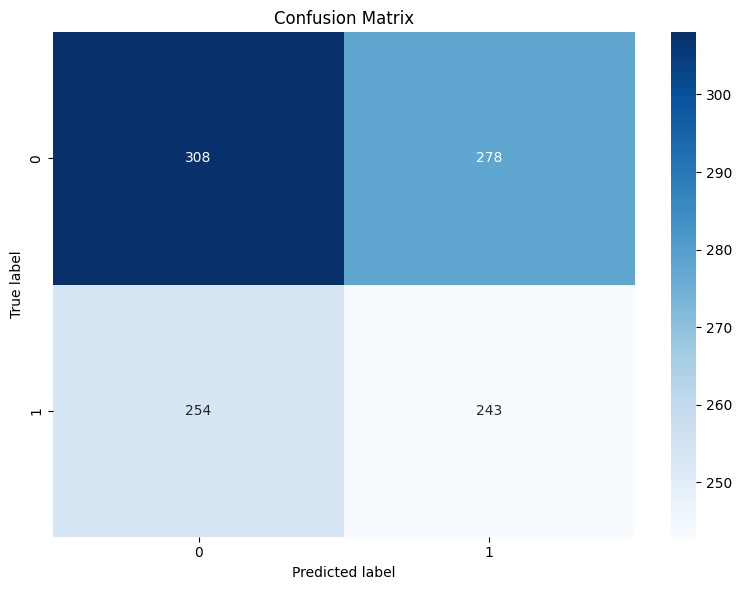

In [15]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [16]:
feature_columns = X.columns.copy()
#feature_columns = feature_columns.get_level_values('Price').tolist()

In [17]:
# Visualize feature importance

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=True)  # Sort ascending for better visualization
feature_importance

feature  importance
5       Close    0.094214
8        Open    0.094614
7         Low    0.097845
2         ma5    0.099981
6        High    0.100114
3        ma10    0.107306
4    Momentum    0.128189
1  Volatility    0.137625
0     Returns    0.140113

In [18]:
# -------------------------------
# 5. Define Pattern Recognition Functions
# -------------------------------
def is_bullish_engulfing(prev, curr):
    """
    Bullish Engulfing:
      - Previous candle is bearish (Close < Open)
      - Current candle is bullish (Close > Open)
      - Current candle's body engulfs the previous candle's body
    """
    if (prev['Close'] < prev['Open']) and (curr['Close'] > curr['Open']):
        if (curr['Open'] < prev['Close']) and (curr['Close'] > prev['Open']):
            return True
    return False

def is_bearish_engulfing(prev, curr):
    """
    Bearish Engulfing:
      - Previous candle is bullish (Close > Open)
      - Current candle is bearish (Close < Open)
      - Current candle's body engulfs the previous candle's body
    """
    if (prev['Close'] > prev['Open']) and (curr['Close'] < curr['Open']):
        if (curr['Open'] > prev['Close']) and (curr['Close'] < prev['Open']):
            return True
    return False

In [19]:
# Bar UpDown

def is_bullish_bar(prev, curr):
    """
    Bullish Bar:
        - Previous candle is bearish (Close < Open)
        - Current candle is bullish (Close > Open)
        """
    if (prev['Close'] < prev['Open']) and (curr['Close'] > curr['Open']):
        return True


def is_bearish_bar(prev, curr):
    """
    Bearish Bar:
        - Previous candle is bullish (Close > Open)
        - Current candle is bearish (Close < Open)
        """
    if (prev['Close'] > prev['Open']) and (curr['Close'] < curr['Open']):
        return True

In [20]:
df_test.head()

Open     High      Low    Close  Volume
Datetime                                                             
2025-01-01 19:00:00-05:00  1.03506  1.03565  1.03473  1.03520      -1
2025-01-01 20:00:00-05:00  1.03520  1.03608  1.03441  1.03578      -1
2025-01-01 21:00:00-05:00  1.03578  1.03713  1.03576  1.03710      -1
2025-01-01 22:00:00-05:00  1.03710  1.03741  1.03682  1.03716      -1
2025-01-01 23:00:00-05:00  1.03716  1.03758  1.03664  1.03692      -1

In [21]:
X, y = prepare_data(df_test, sma_window=14)
df_test

/var/folders/b9/n8g7w60s6s50jwpyrnbrw1m80000gn/T/ipykernel_22553/3130582444.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/b9/n8g7w60s6s50jwpyrnbrw1m80000gn/T/ipykernel_22553/3130582444.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/b9/n8g7w60s6s50jwpyrnbrw1m80000gn/T/ipykernel_22553/3130582444.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Open     High      Low    Close  Volume  \
Datetime                                                                
2025-01-01 19:00:00-05:00  1.03506  1.03565  1.03473  1.03520      -1   
2025-01-01 20:00:00-05:00  1.03520  1.03608  1.03441  1.03578      -1   
2025-01-01 21:00:00-05:00  1.03578  1.03713  1.03576  1.03710      -1   
2025-01-01 22:00:00-05:00  1.03710  1.03741  1.03682  1.03716      -1   
2025-01-01 23:00:00-05:00  1.03716  1.03758  1.03664  1.03692      -1   
...                            ...      ...      ...      ...     ...   
2025-02-17 07:00:00-05:00  1.04818  1.04849  1.04685  1.04722      -1   
2025-02-17 08:00:00-05:00  1.04722  1.04765  1.04670  1.04742      -1   
2025-02-17 09:00:00-05:00  1.04742  1.04793  1.04713  1.04783      -1   
2025-02-17 10:00:00-05:00  1.04783  1.04842  1.04742  1.04796      -1   
2025-02-17 11:00:00-05:00  1.04796  1.04831  1.04767  1.04786      -1   

                            Returns       SMA       Std  Candle_Binary  \
Datetime                                                                 
2025-01-01 19:00:00-05:00       NaN       NaN       NaN              0   
2025-01-01 20:00:00-05:00  0.000560       NaN       NaN              1   
2025-01-01 21:00:00-05:00  0.001274       NaN       NaN              1   
2025-01-01 22:00:00-05:00  0.000058       NaN       NaN              1   
2025-01-01 23:00:00-05:00 -0.000231       NaN       NaN              0   
...                             ...       ...       ...            ...   
2025-02-17 07:00:00-05:00 -0.000916  1.048806  0.001003              0   
2025-02-17 08:00:00-05:00  0.000191  1.048703  0.001068              1   
2025-02-17 09:00:00-05:00  0.000391  1.048604  0.001081              1   
2025-02-17 10:00:00-05:00  0.000124  1.048420  0.000938              1   
2025-02-17 11:00:00-05:00 -0.000095  1.048259  0.000808              0   

                           Momentum  Volatility       ma5      ma10  \
Datetime                                                              
2025-01-01 19:00:00-05:00       NaN         NaN       NaN       NaN   
2025-01-01 20:00:00-05:00       NaN         NaN       NaN       NaN   
2025-01-01 21:00:00-05:00       NaN         NaN       NaN       NaN   
2025-01-01 22:00:00-05:00       NaN         NaN       NaN       NaN   
2025-01-01 23:00:00-05:00       NaN         NaN  1.036432       NaN   
...                             ...         ...       ...       ...   
2025-02-17 07:00:00-05:00  -0.00104    0.000965  1.047826  1.048455   
2025-02-17 08:00:00-05:00  -0.00001    0.000912  1.047824  1.048251   
2025-02-17 09:00:00-05:00   0.00042    0.000929  1.047908  1.048079   
2025-02-17 10:00:00-05:00  -0.00093    0.000580  1.047722  1.047977   
2025-02-17 11:00:00-05:00  -0.00032    0.000509  1.047658  1.047846   

                                 RSI  Up_Bar  Down_Bar        pips  
Datetime                                                            
2025-01-01 19:00:00-05:00        NaN   False     False         NaN  
2025-01-01 20:00:00-05:00        NaN   False     False   56.027821  
2025-01-01 21:00:00-05:00        NaN   False     False  127.440190  
2025-01-01 22:00:00-05:00        NaN   False     False    5.785363  
2025-01-01 23:00:00-05:00        NaN   False     False  -23.140113  
...                              ...     ...       ...         ...  
2025-02-17 07:00:00-05:00  40.701754   False     False  -91.587323  
2025-02-17 08:00:00-05:00  41.724138   False     False   19.098184  
2025-02-17 09:00:00-05:00  42.057143   False     False   39.143801  
2025-02-17 10:00:00-05:00  33.025099   False     False   12.406593  
2025-02-17 11:00:00-05:00  34.435262   False     False   -9.542349  

[785 rows x 17 columns]

In [25]:
# -------------------------------
# 6. Simulate Trading Starting January 2, 2025
# -------------------------------
# We simulate by iterating over the test set (daily candles)
# At the start of each day we use the previous day's features to predict today's move.
# Trading assumptions:
# - If signal is bullish (1), take a long position: profit = (Close - Open)
# - If signal is bearish (0), take a short position: profit = (Open - Close)
# - Capital update per trade is computed on a notional unit basis.
capital = 100000.0  # starting capital in USD
trades = []
l_trades_quantity = 0
s_trades_quantity = 0
features_to_predict = ['Returns', 'Volatility', 'ma5', 'ma10', 'Momentum', 'Close', 'High', 'Low', 'Open']

# Iterate from the second day of the test period onward so we have a "previous" candle.
for i in range(1, len(df_test)):
    today = df_test.iloc[i]
    yesterday = df_test.iloc[i-1]
    day_before_yesterday = df_test.iloc[i-2]
    
    # Use yesterday's features to predict today's outcome (model was trained to predict next candle's direction)
    model_signal = rf_model.predict([yesterday[features_to_predict].values])[0]
    
    # Apply pattern strategy: if a clear bullish or bearish engulfing pattern is detected,
    # use that signal to override the model prediction.
    pattern_signal = 2
    if is_bullish_bar(day_before_yesterday, yesterday):
        pattern_signal = 1
    elif is_bearish_bar(day_before_yesterday, yesterday):
        pattern_signal = 0
    
    # Final signal: pattern confirmation takes precedence if available.
    signal = 2
    #signal = pattern_signal if pattern_signal is not None else model_signal
    signal = model_signal

    # Final signal Matching both predicted and pattern:
    #if (pattern_signal == model_signal):
    #    signal = pattern_signal
    
    profit = 0.0  # Initialize profit to 0.0 if no trade is made.
    # Simulate trade: enter at the Open and exit at the Close of the day.
    if signal == 1:
        profit = today['Close'] - today['Open']
        profit = (profit * 100000) - 2
        l_trades_quantity += 1
    if signal == 0:
        profit = today['Open'] - today['Close']
        profit = (profit * 100000) - 2
        s_trades_quantity += 1
    
    capital += profit  # Update capital (note: this is a simplified model, not accounting for leverage or trade sizing)
    trades.append({
        'date': today.name,
        'ms': model_signal,
        'ps': pattern_signal,
        's': signal,
        'Open': today['Open'],
        'Close': today['Close'],
        'profit': profit,
        'capital': capital
    })

# Convert trading simulation results to a DataFrame and output results
trades_df = pd.DataFrame(trades)
print("\nTrading Simulation Results:")
print(trades_df.head(30))
print(f"\nLong Trades Quantity: {l_trades_quantity}, " + "\nShort Trades Quantity: ", s_trades_quantity)
print("\nFinal Capital: $", round(capital, 2))

/Users/jcamilovasquezm/visualStudioProjects/TWS_IBKR_Trading/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/jcamilovasquezm/visualStudioProjects/TWS_IBKR_Trading/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/jcamilovasquezm/visualStudioProjects/TWS_IBKR_Trading/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/jcamilovasquezm/visualStudioProjects/TWS_IBKR_Trading/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/jcamilovasquezm/visualStudioProjects/TWS_


Trading Simulation Results:
                        date  ms  ps  s     Open    Close  profit   capital
0  2025-01-01 20:00:00-05:00   1   1  1  1.03520  1.03578    56.0  100056.0
1  2025-01-01 21:00:00-05:00   1   2  1  1.03578  1.03710   130.0  100186.0
2  2025-01-01 22:00:00-05:00   1   2  1  1.03710  1.03716     4.0  100190.0
3  2025-01-01 23:00:00-05:00   1   2  1  1.03716  1.03692   -26.0  100164.0
4  2025-01-02 00:00:00-05:00   1   0  1  1.03692  1.03638   -56.0  100108.0
5  2025-01-02 01:00:00-05:00   1   2  1  1.03638  1.03638    -2.0  100106.0
6  2025-01-02 02:00:00-05:00   1   2  1  1.03638  1.03628   -12.0  100094.0
7  2025-01-02 03:00:00-05:00   0   2  0  1.03628  1.03628    -2.0  100092.0
8  2025-01-02 04:00:00-05:00   1   2  1  1.03628  1.03515  -115.0   99977.0
9  2025-01-02 05:00:00-05:00   1   2  1  1.03515  1.03167  -350.0   99627.0
10 2025-01-02 06:00:00-05:00   1   2  1  1.03167  1.03321   152.0   99779.0
11 2025-01-02 07:00:00-05:00   1   1  1  1.03321  1.03182  

/Users/jcamilovasquezm/visualStudioProjects/TWS_IBKR_Trading/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/jcamilovasquezm/visualStudioProjects/TWS_IBKR_Trading/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/jcamilovasquezm/visualStudioProjects/TWS_IBKR_Trading/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/jcamilovasquezm/visualStudioProjects/TWS_IBKR_Trading/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/jcamilovasquezm/visualStudioProjects/TWS_

# Model in Action

In [21]:
# MODEL IN ACTION
# TRAINING AND THEN USING THE TRAINED MODEL TO PREDICT NEXT DAYS CANDLE

from datetime import date, timedelta


# Example usage
symbol = 'BTCUSDT' # Trading pair symbol
interval = '1h' # Time interval (e.g., '1h', '1d')
lookback = '1 year ago' # Lookback period
# Fetch data
#df = get_historical_klines_lookback(symbol, interval, lookback)
df_training = get_historical_klines_range(symbol, interval, "2022-01-01", "2024-12-28")

periods = range(1, 31)
increase = 1
predictions = []

X, y = prepare_data(df_training, sma_window=14)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")

print("\nMean Squared Error Report:")
print(mean_squared_error(y_test,y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1640995200000, '46216.93000000', '46731.39000000', '46208.37000000', '46656.13000000', '1503.33095000', 1640998799999, '69879986.39049930', 38608, '806.06536000', '37462156.91764400', '0'], [1640998800000, '46656.14000000', '46949.99000000', '46574.06000000', '46778.14000000', '943.81539000', 1641002399999, '44127148.11760220', 31872, '491.18067000', '22963272.85537420', '0'], [1641002400000, '46778.14000000', '46928.94000000', '46721.96000000', '46811.77000000', '485.16860000', 1641005999999, '22720670.41920010', 24364, '206.35113000', '9662607.06589570', '0'], [1641006000000, '46811.77000000', '46916.63000000', '46760.12000000', '46813.20000000', '562.88971000', 1641009599999, '26363260.46336290', 19882, '248.28212000', '11629376.39696030', '0'], [1641009600000, '46813.21000000', '46887.33000000', '46591.23000000', '46711.05000000', '861.88389000', 1641013199999, '40272043.73838760', 23357, '397.53563000', '18575402.25911010', '0'], [1641013200000, '46711.05000000', '47555.55000000

In [303]:



# Example usage
symbol = 'BTCUSDT' # Trading pair symbol
interval = '1h' # Time interval (e.g., '1h', '1d')
lookback = '1 year ago' # Lookback period
# Fetch data
#df = get_historical_klines_lookback(symbol, interval, lookback)
df_predicting = get_historical_klines_range(symbol, interval, "2025-01-01", "2025-01-28")

[[1735689600000, '93576.00000000', '94509.42000000', '93489.03000000', '94401.14000000', '755.99010000', 1735693199999, '71068810.55946380', 93525, '421.08319000', '39596777.77992590', '0'], [1735693200000, '94401.13000000', '94408.72000000', '93578.77000000', '93607.74000000', '586.53456000', 1735696799999, '55096606.90660080', 79943, '257.42023000', '24187938.32586320', '0'], [1735696800000, '93607.74000000', '94105.12000000', '93594.56000000', '94098.91000000', '276.78045000', 1735700399999, '25974090.63580940', 55078, '185.35204000', '17393770.43224800', '0'], [1735700400000, '94098.90000000', '94098.91000000', '93728.22000000', '93838.04000000', '220.99302000', 1735703999999, '20748041.00640550', 35001, '119.92140000', '11258665.18270000', '0'], [1735704000000, '93838.04000000', '93838.04000000', '93500.00000000', '93553.91000000', '279.46909000', 1735707599999, '26179056.12514950', 38597, '132.98547000', '12460624.76478960', '0'], [1735707600000, '93553.91000000', '93937.19000000

In [304]:
X, y = prepare_data(df_predicting, sma_window=14)
df_predicting.tail(10)

Open       High        Low      Close      Volume  \
Datetime                                                                      
2025-01-27 15:00:00  101920.88  102118.49  100852.00  101112.03  2332.95744   
2025-01-27 16:00:00  101112.03  101250.56   99566.25   99744.00  2339.06542   
2025-01-27 17:00:00   99744.00  100050.02   99049.98   99150.01  1752.65969   
2025-01-27 18:00:00   99150.01   99753.89   98864.00   99180.00  1546.97033   
2025-01-27 19:00:00   99180.00   99952.00   99175.03   99700.02  1234.90229   
2025-01-27 20:00:00   99700.01  101750.40   99606.46  101386.50  1537.60168   
2025-01-27 21:00:00  101386.11  102405.00  100954.00  101349.67  1827.57602   
2025-01-27 22:00:00  101349.67  101961.09  101277.77  101637.18   548.21078   
2025-01-27 23:00:00  101637.18  102183.21  101637.18  102082.83   829.16272   
2025-01-28 00:00:00  102082.83  102892.00  101777.00  101856.01  1185.97000   

                      Returns            SMA          Std  Candle_Binary  \
Datetime                                                                   
2025-01-27 15:00:00 -0.007936  100067.336429  1112.737833              0   
2025-01-27 16:00:00 -0.013530   99977.622143  1081.964569              0   
2025-01-27 17:00:00 -0.005955   99817.220000  1020.270652              0   
2025-01-27 18:00:00  0.000302   99729.360000  1018.253448              1   
2025-01-27 19:00:00  0.005243   99681.212857  1001.217105              1   
2025-01-27 20:00:00  0.016916   99854.797143  1073.898631              1   
2025-01-27 21:00:00 -0.000363  100019.200714  1116.233830              0   
2025-01-27 22:00:00  0.002837  100204.444286  1156.376732              1   
2025-01-27 23:00:00  0.004385  100394.333571  1234.089958              1   
2025-01-28 00:00:00 -0.002222  100641.710000  1145.966308              0   

                           RSI  Up_Bar  Down_Bar         pips  
Datetime                                                       
2025-01-27 15:00:00  48.940262   False      True  -793.615519  
2025-01-27 16:00:00  43.914481   False     False -1352.984407  
2025-01-27 17:00:00  39.324753   False     False  -595.514517  
2025-01-27 18:00:00  43.568297   False     False    30.247097  
2025-01-27 19:00:00  46.645259   False     False   524.319419  
2025-01-27 20:00:00  61.779721   False     False  1691.554325  
2025-01-27 21:00:00  61.216366   False      True   -36.326335  
2025-01-27 22:00:00  62.298632   False     False   283.681239  
2025-01-27 23:00:00  62.529776   False     False   438.471433  
2025-01-28 00:00:00  67.663058   False     False  -222.192116

In [306]:

# Make predictions for all data
all_predictions = rf_model.predict(X)
#all_probabilities = rf_model.predict_proba(X)

# Create a DataFrame with all data and predictions

full_results_df = X.copy()
full_results_df['Actual'] = y
full_results_df['Predicted'] = all_predictions
#full_results_df.reset_index(inplace = True)
#full_results_df.columns = full_results_df.columns.droplevel('Ticker')
full_results_df['Close'] = df_predicting['Close']
full_results_df['Returns'] = full_results_df['Close'].pct_change()
full_results_df['pips'] = full_results_df['Returns'] * 100000

"""
# Add probability scores
if rf_model.classes_.shape[0] == 2:  # binary classification
    full_results_df['Probability'] = all_probabilities[:, 1]
else:  # multi-class classification
    for i, class_name in enumerate(rf_model.classes_):
        full_results_df[f'Probability_{class_name}'] = all_probabilities[:, i]
"""
# Reset index

accuracy = accuracy_score(y, all_predictions)

print(f"Model Accuracy: {accuracy:.2f}")

print("\nMean Squared Error Report:")
print(mean_squared_error(y, all_predictions))

print("\nClassification Report:")
print(classification_report(y, all_predictions))

print("\nConfusion Matrix:")
cm = confusion_matrix(y, all_predictions)
print(cm)


Model Accuracy: 0.50

Mean Squared Error Report:
0.5046296296296297

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.12      0.18       321
           1       0.50      0.87      0.63       327

    accuracy                           0.50       648
   macro avg       0.48      0.49      0.41       648
weighted avg       0.48      0.50      0.41       648


Confusion Matrix:
[[ 37 284]
 [ 43 284]]


In [ ]:
# 